In [1]:
#| include: false
%matplotlib inline

In [2]:
#| default_exp feature_extraction
#| export
import os
import pickle
from dataclasses import dataclass
import enum

from typing import Optional

import cv2
from dataclasses_json import dataclass_json
import ffmpeg
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.util import crop
import skvideo.io
from tqdm import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm


from experiment_utils.constants import *
from experiment_utils.utils import getLogger

In [3]:
#| export
logger = getLogger()

In [6]:
#| export
def get_video_size(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    width = int(video_info['width'])
    height = int(video_info['height'])
    
    return width, height

def get_video_num_frames(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    
    return int(video_info['nb_frames'])

## Downsampling

Since the data in it's original format is approx 32G in size, we need to downsample

We can downsample in multiple ways:

1. Framerate
2. Color
3. Frame Size

In [14]:
#| export
class ColorSpace(str, enum.Enum):
    RGB = "RGB"
    BW = "BW"

class Crop(str, enum.Enum):
    TOP_RIGHT = "TOPRIGHT"
    NONE =  "NONE"

@dataclass
class DownsampleConfig:
    height: int
    width: int
    fps_ratio: int
    col_space: ColorSpace
    crop: Crop
        
    __MAGIC = 'downsample_'
    
    def __str__(self):
        repr = f'{self.__MAGIC}_{self.width}x{self.height}_{self.fps_ratio}_{self.col_space}'
        if self.crop != Crop.NONE:
            repr += f'_{self.crop}'
        return repr

    @classmethod
    def from_str(cls, downsample_str: str):
        if downsample_str[:len(cls.__MAGIC)] != cls.__MAGIC:
            raise ValueError("Could not create DownsampleConfig from string: " + downsample_str)
        
        width, *rest = downsample_str[len(cls.__MAGIC):].split('x')
        fields = rest[0].split('_')
        
        height, fps_ratio, col_space, *rest = fields

        crop = Crop.NONE
        if len(rest) > 0:
            crop, *rest = rest
        
        return DownsampleConfig(height=int(height),
                                width=int(width),
                                fps_ratio=int(fps_ratio),
                                col_space=ColorSpace(col_space),
                                crop=crop)

In [15]:
#| export
def get_downsampled_frames(input_filename: str, downsample_config: DownsampleConfig) -> np.array:
    cap = cv2.VideoCapture(input_filename)
    
    frames = []
    count = 0
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logger.info('Total frames: %d', total_frames)
    with tqdm(total=total_frames) as progress_bar:
        while cap.isOpened():
            ret, frame = cap.read()

            if ret and count < total_frames:
                count += downsample_config.fps_ratio
                progress_bar.update(downsample_config.fps_ratio)
                cap.set(cv2.CAP_PROP_POS_FRAMES, count)
            else:
                cap.release()
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_image = resize(frame, (downsample_config.height, downsample_config.width))

            if downsample_config.col_space == ColorSpace.BW:
                rgb_weights = [0.2989, 0.5870, 0.1140]
                grayscale_image = np.dot(resized_image[...,:3], rgb_weights)
                int_frame = (grayscale_image * 255).astype(np.uint8)
            else:
                int_frame = (resized_image * 255).astype(np.uint8)
            
            if downsample_config.crop == Crop.TOP_RIGHT:
                height, width, channels = int_frame.shape
                mid_height, mid_width = height // 2, width // 2
                int_frame = int_frame[:mid_height, mid_width:, :]

            frames.append(int_frame)
    
    return frames

In [16]:
def get_sample_videos_paths():
    clips_dir = os.path.join(DATA_DIR, 'clips')
    return [os.path.join(clips_dir, name) for name in os.listdir(clips_dir)]

In [17]:
all_vids = get_sample_videos_paths()
all_vids

['/home/shikhar/dev/csgo-clips-autotrim/data/clips/input',
 '/home/shikhar/dev/csgo-clips-autotrim/data/clips/output',
 '/home/shikhar/dev/csgo-clips-autotrim/data/clips/test_clip_1.mp4']

In [18]:
downsampled_frames = get_downsampled_frames(all_vids[2], DownsampleConfig.from_str('downsample_1920x1080_60_RGB_TOPRIGHT'))

[INFO] 2023-07-17 02:39:50,780 default     : Total frames: 6317
6360it [00:38, 165.68it/s]                          


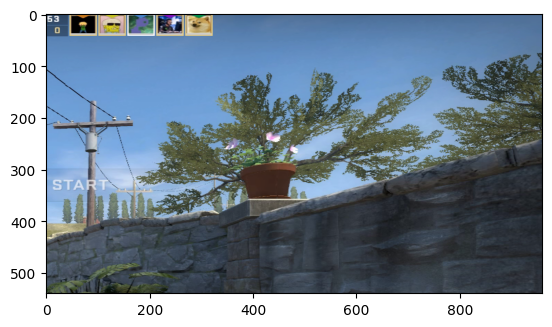

In [19]:
plt.imshow(downsampled_frames[0])

In [ ]:
print(len(downsampled_frames))

106


In [ ]:
downsampled_frames = get_downsampled_frames('/code/data/clips/input/blue_and_ash_fail.mp4', DownsampleConfig.from_str('downsample_1920x1080_60_RGB'))

[INFO] 2022-10-23 13:57:27,982 default     : Total frames: 3599
3600it [00:18, 190.68it/s]                                                                                                                                                                                                                  
